In [ ]:
!pip install opendatasets --quiet

In [ ]:
# по API подключаемся к kaggle и скачиваем нужный датасет
# для этого в colab надо подгрузить файл kaggle.json, который содержит токен и пароль
# после этого в проводнике colab появится папка с данными
import opendatasets as od
import pandas as pd

# {"username":"biwanun1690","key":"2d817845937a4e0f6a59358471001da7"}
od.download( "https://www.kaggle.com/competitions/what-on-the-video")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: biwanun1690
Your Kaggle Key: ··········


100%|██████████| 690M/690M [00:06<00:00, 115MB/s]



Extracting archive ./what-on-the-video/what-on-the-video.zip to ./what-on-the-video


In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import pandas as pd

print(len(os.listdir('/content/what-on-the-video/train')))
print(len(os.listdir('/content/what-on-the-video/test')))

428
435


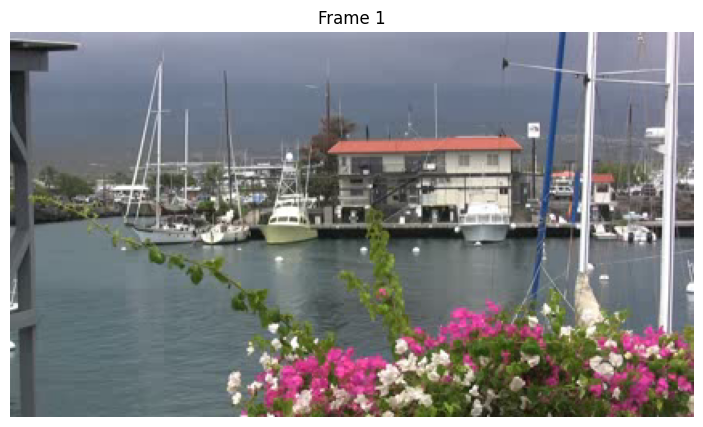

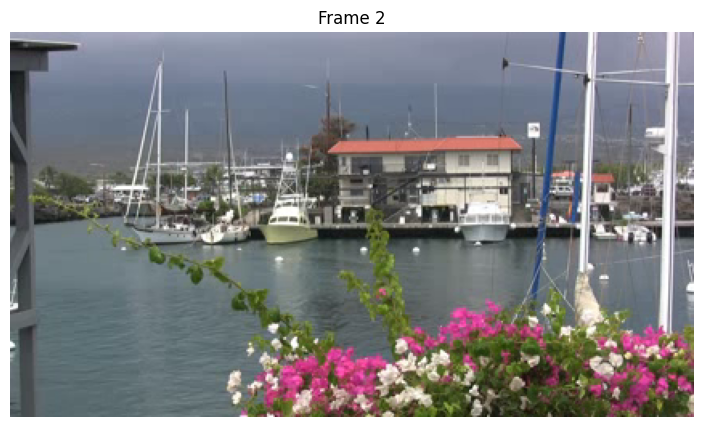

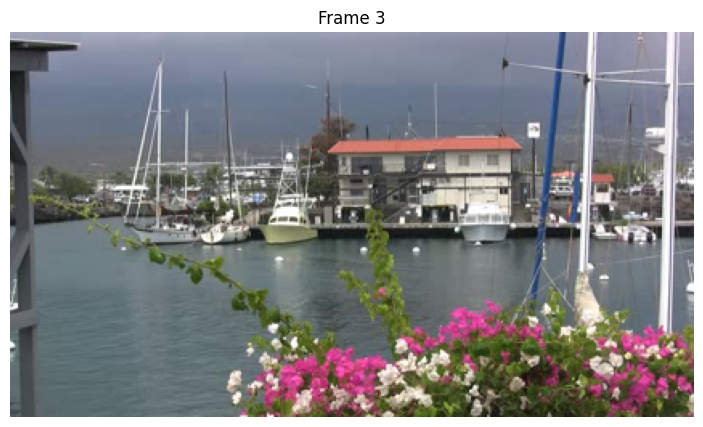

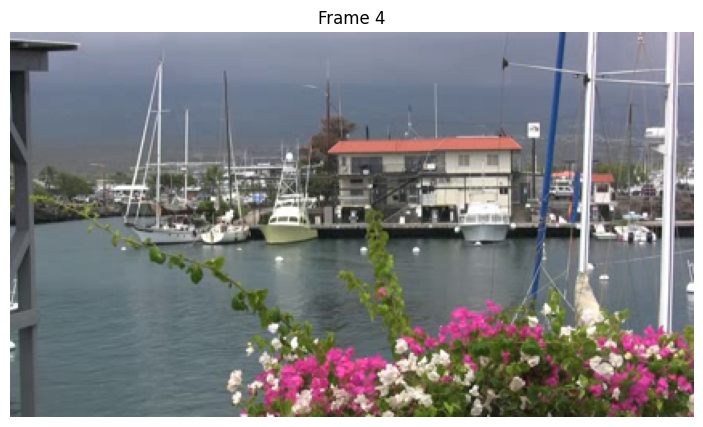

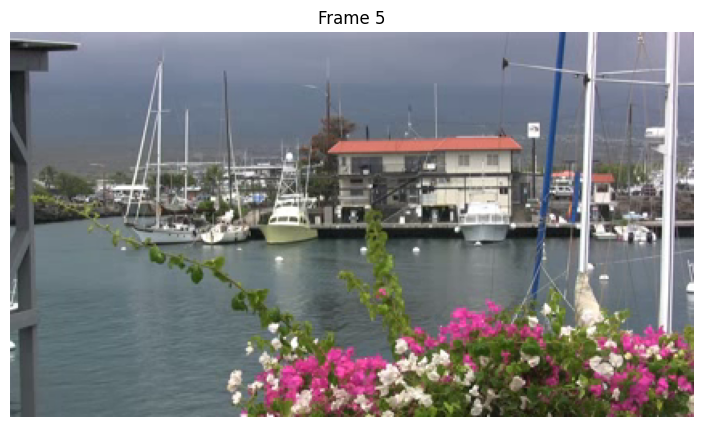

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Для корректного отображения в Colab

# Загружаем видео
video_path = '/content/what-on-the-video/train/000984125-marina-kona-coast-hawaii_preview.mp4'  # Замените на путь к вашему видео
cap = cv2.VideoCapture(video_path)

frames = []  # Список для хранения кадров

# Читаем кадры из видео
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Конвертация BGR → RGB
    frames.append(frame_rgb)

cap.release()

# Выводим первые 5 кадров (можно изменить)
num_frames_to_show = 5
for i in range(num_frames_to_show):
    plt.figure(figsize=(10, 5))
    plt.imshow(frames[i])
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
    plt.show()

In [ ]:
import cv2

# Загружаем видео
video_path = '/content/what-on-the-video/train/000984125-marina-kona-coast-hawaii_preview.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Ошибка: не удалось открыть видео!")
else:
    # Основные параметры
    fps = cap.get(cv2.CAP_PROP_FPS)  # Количество кадров в секунду
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Общее число кадров
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Ширина (пиксели)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Высота (пиксели)
    duration_sec = frame_count / fps  # Длительность в секундах

    print(f"Размер: {width}x{height}")
    print(f"Частота кадров (FPS): {fps}")
    print(f"Всего кадров: {frame_count}")
    print(f"Длительность: {duration_sec:.2f} сек (~{duration_sec / 60:.2f} мин)")

    cap.release()  # Закрываем видео

Размер: 426x240
Частота кадров (FPS): 29.97
Всего кадров: 382
Длительность: 12.75 сек (~0.21 мин)


In [ ]:
df = pd.read_csv('/content/what-on-the-video/train.csv')

df # не для всех есть анотации!!! дозаполнить!!!

,path,labels
0,port_before_sunrise_preview.mp4,sunset
1,Louisiana speeding boat on Mississippi River_p...,cloud
2,170509A_Vietnam_03_preview.mp4,water
3,Croatia water on rocks at high tide pan_previe...,water
4,Arizona zoom on sunset mountain_preview.mp4,sunset
...,...,...
285,bees2_preview.mp4,flower
286,170628_016_preview.mp4,food
287,_import_615fd719c295d0.10594294_preview.mp4,flower
288,_import_616e5ebb6151f5.55336006_preview.mp4,animal


In [ ]:
filenames = df['path'].values
#print(filenames)

for filename in os.listdir('/content/what-on-the-video/train'):
    if filename not in filenames:
      new_row = {'path': filename, 'labels': 0}
      #df = df.append(new_row, ignore_index=True)
      df.loc[len(df)] = [filename, 0]

In [ ]:
df.shape

(428, 2)

In [ ]:
df['labels'] = df['labels'].str.replace('.', ',')

In [ ]:
df['labels'].value_counts()

,count
labels,
water,68
cloud,41
car,33
food,30
sunset,29
flower,29
animal,21
dance,17
"cloud, water",12


In [ ]:
df.shape

(428, 2)

In [ ]:
df.to_csv('train_all.csv', index=False)

In [ ]:
df.columns

Index(['path', 'labels'], dtype='object')

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

class VideoDataset(Dataset):
    def __init__(self, dataframe, video_dir, transform=None, mode='train'):
        self.dataframe = dataframe.reset_index(drop=True)
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        self.label_to_idx = {'animal': 0, 'car': 1, 'cloud': 2,
                             'dance': 3, 'fire': 4, 'flower': 5,
                             'food': 6, 'sunset': 7, 'water': 8,
                             'cloud, water': 9, 'cloud, sunset': 10, 'water, sunset': 11}

        if self.mode == 'train' or self.mode == 'val':
            if 'labels' not in self.dataframe.columns:
                raise ValueError("Dataframe must contain 'label' column in train/val mode.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_path = os.path.join(self.video_dir, row['path'])
        #video_path = row['path']
        cap = cv2.VideoCapture(video_path)
        #video = Image.open(video_path).convert('RGB')

        '''
        frames = []
        #n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        n = 80
        for _ in range(n):
            ret, frame = cap.read()
            if not ret:
                break
            #cadr = Image.open(video_path).convert('RGB')
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame_rgb)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        cap.release()
        '''
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))/2)
        ret, frame = cap.read()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame_rgb)
        if self.transform:
            frame = self.transform(frame)

        if self.mode in ['train', 'val']:
            label = row['labels']
            if isinstance(label, str):
                label = self.label_to_idx[label]
            #return torch.tensor(np.array(frames), dtype=torch.float32), label
            return frame, label
        else:
            #return torch.tensor(np.array(frames), dtype=torch.float32), row['path']
            return frame, row['path']

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) #stratify=df['labels']

print(train_df.shape, val_df.shape)

(232, 2) (58, 2)


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_path = '/content/what-on-the-video/train'
# Для обучения
train_dataset = VideoDataset(train_df, video_dir=train_path, transform=transform, mode='train')

# Для теста или предсказания
val_dataset = VideoDataset(val_df, video_dir=train_path, transform=transform, mode='val')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
for videos, labels in train_loader:
    print("Batch shape:", videos.shape)      # [batch_size, 3, H, W]
    print("Labels shape:", labels.shape)     # [batch_size]
    print("Пример меток:", labels[:5])
    break

Batch shape: torch.Size([16, 3, 128, 128])
Labels shape: torch.Size([16])
Пример меток: tensor([8, 8, 0, 3, 7])


In [ ]:
for images, filenames in val_loader:
    print("Batch shape:", images.shape)
    print("Файлы:", filenames[:5])
    break

Batch shape: torch.Size([16, 3, 128, 128])
Файлы: tensor([7, 1, 2, 4, 8])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet18Classifier(num_classes=12, pretrained=True)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyResNet18Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.model = models.efficientnet_b0(pretrained=pretrained)

        # Заменяем классификатор
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = EfficientNetClassifier(num_classes=12, pretrained=True)
model.to(device)

EfficientNetClassifier(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 6

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} — "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

Epoch 1/6 — Train loss: 0.5634, Train acc: 0.9526 — Val loss: 1.6038, Val acc: 0.5172
Epoch 2/6 — Train loss: 0.4862, Train acc: 0.9698 — Val loss: 1.6069, Val acc: 0.5000
Epoch 3/6 — Train loss: 0.3891, Train acc: 0.9784 — Val loss: 1.6153, Val acc: 0.4655
Epoch 4/6 — Train loss: 0.3338, Train acc: 0.9871 — Val loss: 1.6426, Val acc: 0.4655
Epoch 5/6 — Train loss: 0.3095, Train acc: 0.9784 — Val loss: 1.6263, Val acc: 0.4655
Epoch 6/6 — Train loss: 0.2312, Train acc: 0.9871 — Val loss: 1.6281, Val acc: 0.4828


In [ ]:
test_df = pd.DataFrame(columns=['path'])
#print(filenames)

for filename in os.listdir('/content/what-on-the-video/test'):
    new_row = {'path': filename}
    #test_df = test_df.append(new_row, ignore_index=True)
    test_df.loc[len(test_df)] = [filename]

In [ ]:
test_df.shape

(435, 1)

In [ ]:
test_path = '/content/what-on-the-video/test'
test_dataset = VideoDataset(test_df, video_dir=test_path, transform=transform, mode='test')

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
model.eval()
idx_to_label = {0: 'animal', 1: 'car', 2: 'cloud',
                3: 'dance', 4: 'fire', 5: 'flower',
                6: 'food', 7: 'sunset', 8: 'water',
                9: 'cloud, water', 10: 'cloud, sunset', 11: 'water, sunset'}
all_preds = []
all_filenames = []

with torch.no_grad():
    for images, filenames in test_loader:   # test_loader должен возвращать filenames
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_filenames.extend(filenames)

In [ ]:
all_labels = [idx_to_label[int(i)] for i in all_preds]

#all_labels

In [ ]:
import pandas as pd
submission_df = pd.DataFrame({'index': list(range(len(all_filenames))), 'file_name': all_filenames, 'label': all_labels})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.head()

,index,file_name,label
0,0,Germany Tangermunde Rathhous and statue of Gre...,car
1,1,171124_I1_004_preview.mp4,dance
2,2,France curious alpine clouds time lapse_previe...,cloud
3,3,_import_62a58dfa0a2971.36532340_preview.mp4,dance
4,4,170724_01_Wavesfromabove_preview.mp4,water
